In [9]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from distributions import IndependentNormal, Banana
from samplers import metropolis_hastings_with_noise
import seaborn as sns
import jax
from importlib import reload

Gaussian Proposal, Banana Target

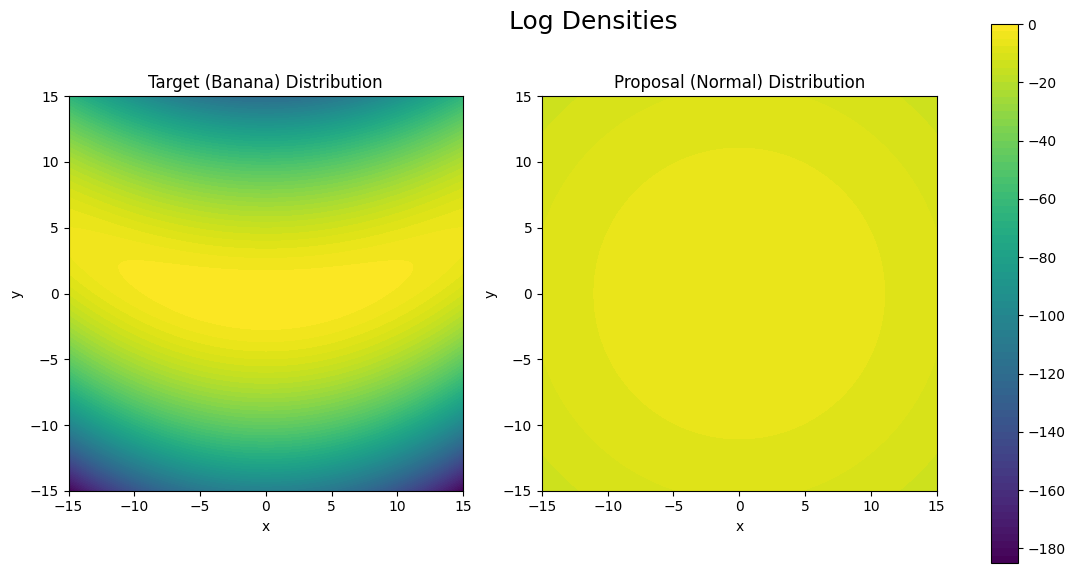

In [3]:
banana = Banana(dim=2, sigma=5.0, b=0.02)
normal = IndependentNormal(2, loc=torch.tensor([0.0, 0.0]), scale=5)

functions = [banana.log_prob, normal.log_prob]
titles = ['Target (Banana) Distribution', 'Proposal (Normal) Distribution']

scale = 15
xlim = (-scale, scale)
ylim = (-scale, scale)

x = np.linspace(*xlim, 400)
y = np.linspace(*ylim, 400)
X, Y = np.meshgrid(x, y)
XY = np.stack((X, Y), axis=-1)

fig, axs = plt.subplots(1, len(functions), figsize=(7 * len(functions), 7))

from plotting_utils import colorbar

levels = 80
for ax, func, title in zip(axs, functions, titles):
    ax.set_aspect('equal')
    Z = func(torch.from_numpy(XY))
    c = ax.contourf(X, Y, Z, levels=levels, cmap='viridis')
    levels = c.levels
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(title)
fig.colorbar(c, ax=axs)
plt.suptitle('Log Densities', y=0.9, size=18);

In [66]:
from samplers import metropolis_hastings_with_noise

n = 100000
acc_rate, mh_samples = metropolis_hastings_with_noise(target=banana, proposal=normal, n_samples=n, noise_std=0)
real_samples = banana.sample((n,))
proposals = normal.sample((n,))
print ('acceptance rate:', acc_rate)

acceptance rate: 0.2478


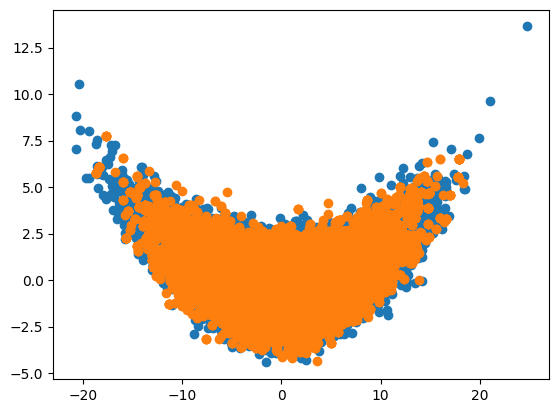

In [64]:
plt.scatter(*real_samples.T)
# plt.scatter(*proposals.T)
plt.scatter(*mh_samples.T)

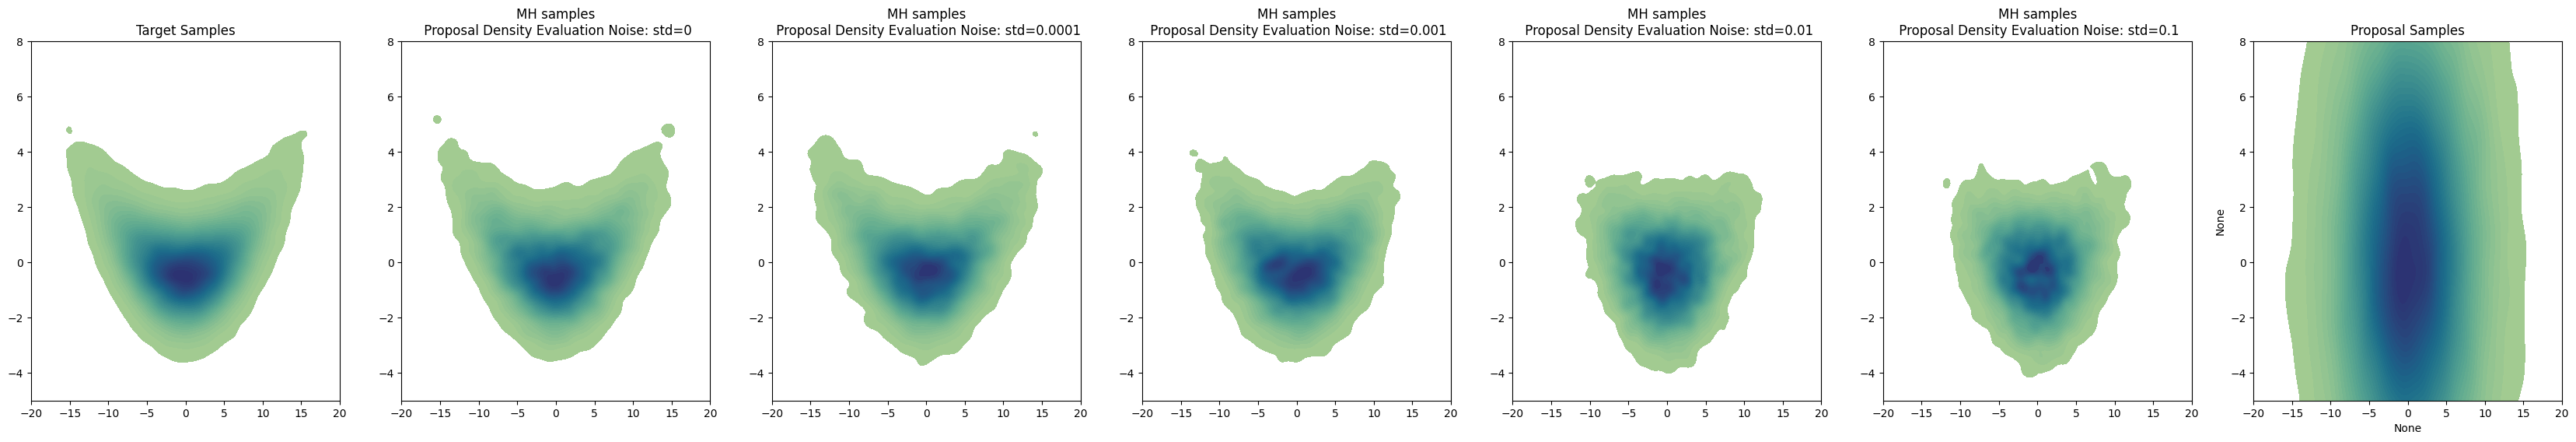

In [67]:
def plot_kde(ax, samples):
    cmap = sns.color_palette("crest", as_cmap=True)
    sns.kdeplot(
        ax = ax,
        x=samples[:, 0],
        y=samples[:, 1],
        fill=True,
        cmap=cmap,
        thresh=0.01,
        levels=40
    )

noise_levels = [0, 0.0001, 0.001, 0.01, 0.1]
K = len(noise_levels)

fig, axs = plt.subplots(ncols=2+K, figsize=(6 * (K + 2), 6))

for ax in axs:
    ax.set_xlim(-20, 20)
    ax.set_ylim(-5, 8)

axs[0].set_title('Target Samples')
plot_kde(axs[0], real_samples)
axs[K + 1].set_title('Proposal Samples')
plot_kde(axs[K+1], proposals)

for ax, noise in zip(axs[1:], noise_levels):
    ax.set_title(f'MH samples\n Proposal Density Evaluation Noise: std={noise}')
    acc_rate, mh_samples = metropolis_hastings_with_noise(target=banana, proposal=normal, n_samples=n, noise_std=noise)
    plot_kde(ax, mh_samples)

In [52]:
import distribution_metrics, samplers
reload(distribution_metrics)
reload(samplers)
from samplers import metropolis_hastings_with_noise
from distribution_metrics import average_total_variation

In [96]:
#Baselines
N = 3000
target_samples = banana.sample((N,))
proposals = normal.sample((N,)).numpy()
_, mh0_samples = metropolis_hastings_with_noise(target=banana, proposal=normal, n_samples=N, noise_std=0)
mh0_target_atv = average_total_variation(true_samples, mh0_samples, n_samples=1500, n_steps=20)
proposal_target_atv = average_total_variation(true_samples, proposals, n_samples=1500, n_steps=20)
print(mh0_target_atv, proposal_target_atv)

0.04562814 0.23219712


CPU times: total: 2min 28s
Wall time: 1min 52s


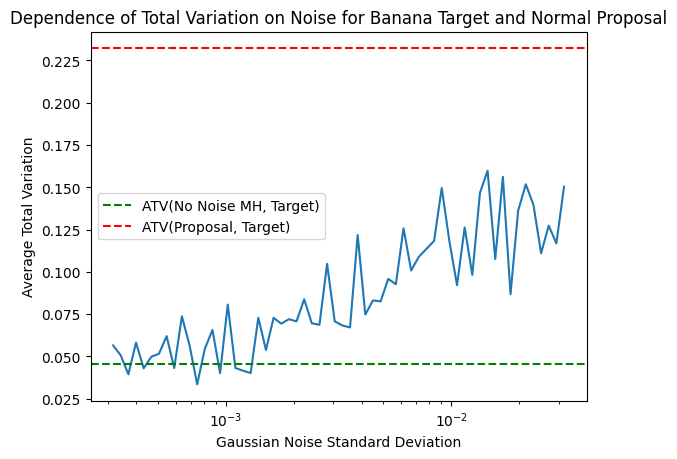

In [99]:
%%time

N = 3000
atvs = []
noise_levels = np.logspace(-3.5, -1.5, 60)
true_samples = banana.sample((N,))
for noise in noise_levels:
    acc_rate, mh_samples = metropolis_hastings_with_noise(target=banana, proposal=normal, n_samples=N, noise_std=noise)
    atvs.append(average_total_variation(true_samples, mh_samples, n_samples=1500, n_steps=4))

fig, ax = plt.subplots()
ax.plot(noise_levels, atvs)

ax.axhline(y=mh0_target_atv, label='ATV(No Noise MH, Target)', linestyle='--', color='green')
ax.axhline(y=proposal_target_atv, label='ATV(Proposal, Target)', linestyle='--', color='red')
ax.set_xlabel('Gaussian Noise Standard Deviation')
ax.set_ylabel('Average Total Variation')
ax.set_title('Dependence of Total Variation on Noise for Banana Target and Normal Proposal')
ax.set_xscale('log')
ax.legend();

CPU times: total: 37.7 s
Wall time: 29.2 s


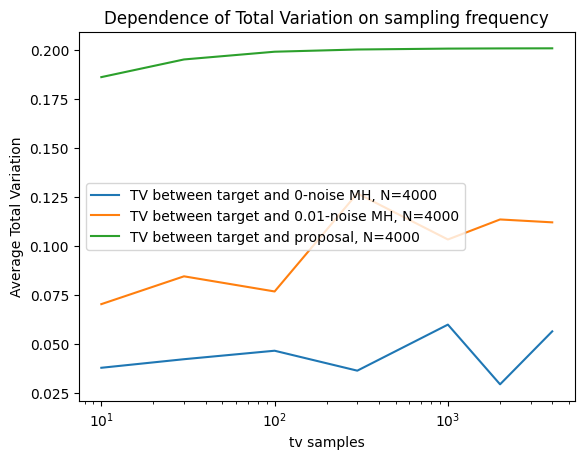

In [75]:
%%time

tv_samples_options = [10, 30, 100, 300, 1000, 2000, 4000]
prop_atvs = []
mh0_atvs = []
mh001_atvs = []
N = 4000
proposals = normal.sample((N,)).numpy()
true_samples = banana.sample((N,))
for tv_samples in tv_samples_options:
    _, mh_samples = metropolis_hastings_with_noise(target=banana, proposal=normal, n_samples=N, noise_std=0)
    mh0_atvs.append(average_total_variation(true_samples, mh_samples, n_samples=tv_samples, n_steps=3))
    _, mh_samples = metropolis_hastings_with_noise(target=banana, proposal=normal, n_samples=N, noise_std=0.01)
    mh001_atvs.append(average_total_variation(true_samples, mh_samples, n_samples=tv_samples, n_steps=3))
    prop_atvs.append(average_total_variation(true_samples, proposals, n_samples=tv_samples, n_steps=3))

fig, ax = plt.subplots()
ax.plot(tv_samples_options, mh0_atvs, label=f'TV between target and 0-noise MH, N={N}')
ax.plot(tv_samples_options, mh001_atvs, label=f'TV between target and 0.01-noise MH, N={N}')
ax.plot(tv_samples_options, prop_atvs, label=f'TV between target and proposal, N={N}')
ax.set_xlabel('tv samples')
ax.set_ylabel('Average Total Variation')
ax.set_title('Dependence of Total Variation on sampling frequency')
ax.set_xscale('log')
ax.legend();